In [13]:
import seaborn as sns
import scipy.sparse as sparse
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math as m

Ввод данных из файла

In [26]:
def MyData():
    # путь к файлу
    f = open("newex1", "r")
    all_file = f.readlines()
    # Юнг, Пуассон
    mu = float(all_file[0].split(' ')[0]) 
    E = float(all_file[0].split(' ')[1])*10
    # количество узлов
    Num_nod = int(all_file[1])
    #список узлов с координатами
    Coord_nod = np.matrix([-1,-1])
    for i in range(2,Num_nod + 2):
        this_line = all_file[i].split(' ')
        Coord_nod = np.append(Coord_nod,[[float(this_line[0]),float(this_line[1])]],axis = 0)
    Coord_nod = np.delete(Coord_nod,0,axis = 0)
    # количество конечных элементов
    Num_el = int(all_file[Num_nod+2])
    #список элементов с соответсвующими узлами
    el_nod = np.matrix([-1,-1,-1])
    for i in range(Num_nod+3,Num_nod+3+Num_el):
        this_line = all_file[i].split(' ')
        el_nod = np.append(el_nod,[[int(this_line[0]),int(this_line[1]),int(this_line[2])]],axis = 0)
    el_nod = np.delete(el_nod,0,axis = 0)
    # ограничения движения 
    lim_in_nod = int(all_file[Num_nod+3+Num_el])
    lim = np.matrix([-1,-1])
    for i in range(Num_nod+4+Num_el,Num_nod+4+Num_el+lim_in_nod):
        this_line = all_file[i].split(' ')
        lim = np.append(lim,[[float(this_line[0]),float(this_line[1])]],axis = 0)
    lim = np.delete(lim,0,axis = 0)
    # количество узлов, в которых приложены усилия
    eff_in_nod = int(all_file[Num_nod+4+Num_el+lim_in_nod])
    eff = np.matrix([-1,-1,-1])
    for i in range(Num_nod+5+Num_el+lim_in_nod,Num_nod+5+Num_el+lim_in_nod+eff_in_nod):
        this_line = all_file[i].split(' ')
        eff = np.append(eff,[[float(this_line[0]),float(this_line[1]),float(this_line[2])]],axis = 0)
    eff = np.delete(eff,0,axis = 0)

    f.close()
    
    D = E/(1 - mu*mu)*np.array([[1,mu,0],[mu,1,0],[0,0, (1-mu)/2]])
    #D = E*(1-mu)/((1+mu)*(1-2*mu))*np.array([[1,mu/(1-mu),0],[mu/(1-mu),1,0],[0,0,(1-2*mu)/(2*(1-mu))]])
    
    return el_nod,Coord_nod,D,eff,Num_nod,Num_el,lim,D


In [27]:
# ищем матрицу D


In [28]:
# умножение матрицы на матрицу
def d(A,B):
    ans = np.zeros((A.shape[0],B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(B.shape[0]):
                ans[i,j] += A[i,k] * B[k,j]
    return ans

In [29]:
# убираем сингулярность
def K_ok(A,lim):
    print(lim)
    for i in range(len(lim)):
        for j in range(len(A)):
            if lim[i,0] == j:
                if lim[i,1] == 1:
                    ii = int(lim[i,0]*2)
                    for k in range(len(A)):
                        if j == k:
                            A[ii,j] = 1
                        else:
                            A[ii,j] = 0
                            A[j,ii] = 0
                if lim[i,1] == 2:
                    ii = int(lim[i,0]*2+1)
                    for k in range(len(A)):
                        if j == k:
                            A[ii,j] = 1
                        else:
                            A[ii,j] = 0
                            A[j,ii] = 0
                if lim[i,1] == 3:
                    ii1 = int(lim[i,0]*2)
                    ii0 = int(lim[i,0]*2+1)
                    
                    for k in range(len(A)):
                            A[ii1,k] = 0
                            A[k,ii1] = 0
                            A[ii0,k] = 0
                            A[k,ii0] = 0
                    A[ii1,ii1] = 1
                    A[ii0,ii0] = 1
    return A

In [30]:
#функция которой дают номера узлов, соответствующих элементу,
# и матрицу с координатами, а она считает определитель*2
def Det2(xi,yi,xj,yj,xk,yk):
    return (xj*(yk - yi) + xi*(yj - yk) + xk*(yi - yj))

In [31]:
def make_B(num,el_nod,Coord_nod,D,eff,lim):
    x,y,z = sp.symbols('x, y, z')
    ui,uj,uk = sp.var('ui uj uk')
    vi,vj,vk = sp.var('vi vj vk')
    wi,wj,wk = sp.var('wi wj wk')
    n = el_nod[num,0]
    m = el_nod[num,1]
    t = el_nod[num,2]
    # для конкретного элемента ищем координаты узлов
    xi = Coord_nod[n,0]
    yi = Coord_nod[n,1]
    xj = Coord_nod[m,0]
    yj = Coord_nod[m,1]
    xk = Coord_nod[t,0]
    yk = Coord_nod[t,1]
    # пользуемся формулами со слайда 29
    Det = Det2(xi,yi,xj,yj,xk,yk)
    ai = (xj*yk - xk*yj)/Det
    aj = (xk*yi - xi*yk)/Det
    ak = (xi*yj - xj*yi)/Det
    bi = (yj - yk)/Det
    bj = (yk - yi)/Det
    bk = (yi - yj)/Det
    ci = (xk - xj)/Det
    cj = (xi - xk)/Det
    ck = (xj - xi)/Det
   
    # собираем матрицу B
    Bi =[[bi, 0],[0, ci],[ci, bi]]
    Bj =[[bj, 0],[0, cj],[cj, bj]] 
    Bk =[[bk, 0],[0, ck],[ck, bk]] 
    B0 = np.hstack([Bi, Bj, Bk])
    
    return B0

In [32]:
def make_K(num,el_nod,Coord_nod,D,eff_final,lim):
    Bi = make_B(num,el_nod,Coord_nod,D,eff_final,lim)
    n = el_nod[num,0]
    m = el_nod[num,1]
    t = el_nod[num,2]
    xi = Coord_nod[n,0]
    yi = Coord_nod[n,1]
    xj = Coord_nod[m,0]
    yj = Coord_nod[m,1]
    xk = Coord_nod[t,0]
    yk = Coord_nod[t,1]

    return (Det2(xi,yi,xj,yj,xk,yk)/2)*Bi.T.dot(D).dot(Bi)

In [33]:
#make_K(0,el_nod,Coord_nod,D,eff) 

In [34]:
# глобальная K 
def sum_K(A,B,ind,num):
    a = len(A)
    b = len(B)
    for i in range(ind.shape[1]):
        for j in range(ind.shape[1]):
            ii = ind[0,i]
            jj = ind[0,j]
            A[ii*2:ii*2+2,jj*2:jj*2+2] += B[i*2:i*2+2,j*2:j*2+2]
    return A
        

In [35]:
# генерируем вектор правых частей
def right(eff,Num_nod):
    a = np.zeros(Num_nod*2)
    print(eff)
    for i in range(len(eff)):
        for j in range(Num_nod):
            if eff[i,0] == j:
                a[j*2] = eff[i,1]
                a[j*2+1] = eff[i,2]
            
    return a

In [36]:
def FEM():
    el_nod,Coord_nod,D,eff,Num_nod,Num_el,lim,D=MyData()
    rig = right(eff,Num_nod)
    K0 = np.zeros((Num_nod*2,Num_nod*2))
    for i in range(0,Num_el):
        ind = el_nod[i,:]
        K0 = sum_K(K0,make_K(i,el_nod,Coord_nod,D,eff,lim),ind[0],i)
    
    K0 = K_ok(K0,lim)
    
    U = np.linalg.solve(K0,rig.T)
    max_sig = 0
    max_sig_i = -1
    m_s=0
    m_s_i=-1
    for i in range(Num_el):
        B = make_B(i,el_nod,Coord_nod,D,eff,lim)
        Ui = np.zeros((6))
        Ui[0] = U[el_nod[i,0]*2]
        Ui[1] = U[el_nod[i,0]*2+1]
        Ui[2] = U[el_nod[i,1]*2]
        Ui[3] = U[el_nod[i,1]*2+1]  
        Ui[4] = U[el_nod[i,2]*2]
        Ui[5] = U[el_nod[i,2]*2+1] 
        #деформации (эпсилон)    
        Eps = B.dot(Ui)
        # напряжения(сигма)
        Nap = D.dot(Eps) 
        NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]])
        Sig,s = np.linalg.eig(NapM) 
        
        now_sig = m.sqrt(Nap[0]**2-Nap[0]*Nap[1]+Nap[1]**2+3*Nap[2]**2)
        if now_sig > max_sig:
            max_sig = now_sig
            max_sig_i = i
        #now_sig = max(abs(Sig))
        #if n_s > m_s:
         #   m_s = n_s
          #  m_s_i = i
        #print('Модуль максимального главного напряжения ',max(abs(Sig)))
        #print('Деформации в ',i,' элементе',Eps)
        #print('Напряжения в ',i,' элементе',Nap)
    a = Coord_nod[el_nod[max_sig_i,0],:]
    b = Coord_nod[el_nod[max_sig_i,1],:]
    c = Coord_nod[el_nod[max_sig_i,2],:]
    print(a,max_sig)
    plt.plot(Coord_nod[:,0],Coord_nod[:,1],'.')
    plt.plot(b[0,0],b[0,1],'r.')
    plt.plot(a[0,0],a[0,1],'r.')
    plt.plot(c[0,0],c[0,1],'r.')


    return 


[[20.   -0.5   0.  ]
 [40.   -0.5   0.  ]
 [41.   -0.5   0.  ]
 [42.   -0.5   0.  ]
 [43.   -0.5   0.  ]
 [44.   -0.5   0.  ]
 [45.   -0.5   0.  ]
 [46.   -0.5   0.  ]
 [47.   -0.5   0.  ]
 [48.   -0.5   0.  ]
 [49.   -0.5   0.  ]
 [50.   -0.5   0.  ]
 [51.   -0.5   0.  ]
 [52.   -0.5   0.  ]
 [53.   -0.5   0.  ]
 [54.   -0.5   0.  ]
 [55.   -0.5   0.  ]
 [56.   -0.5   0.  ]
 [57.   -0.5   0.  ]
 [58.   -0.25  0.  ]
 [59.   -0.25  0.  ]
 [60.    0.25  0.  ]
 [80.    0.25  0.  ]
 [81.    0.5   0.  ]
 [82.    0.5   0.  ]
 [83.    0.5   0.  ]
 [84.    0.5   0.  ]
 [85.    0.5   0.  ]
 [86.    0.5   0.  ]
 [87.    0.5   0.  ]
 [88.    0.5   0.  ]
 [89.    0.5   0.  ]
 [90.    0.5   0.  ]
 [91.    0.5   0.  ]
 [92.    0.5   0.  ]
 [93.    0.5   0.  ]
 [94.    0.5   0.  ]
 [95.    0.5   0.  ]
 [96.    0.5   0.  ]
 [97.    0.5   0.  ]
 [98.    0.5   0.  ]
 [99.    0.5   0.  ]]
[]
[[-0.02938926 -0.04045085]] 31.186598134751975


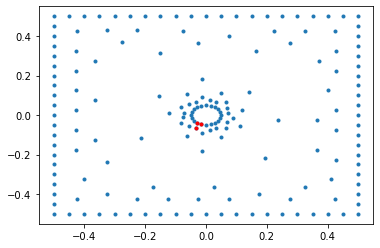

In [37]:
FEM()